# Predict Churn at the 2nd order

## Import modules

In [1]:
# Basic modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Datetime modules
from datetime import datetime, timedelta
from time import time

# Setting pandas dataframe parameters
pd.set_option('display.max_columns', None)

# Set the random state variable
random_state_nb= 77

# Pipeline and CV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer, LabelEncoder

# Metrics and Assessment
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Bayes search
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Permutation Importance
from sklearn.inspection import permutation_importance

# Save models
import pickle

# Model Explainability
import shap

## ROC Curve

In [2]:
def plot_roc(y_test, proba_preds):

    # create linear line
    base_probs = [0 for _ in range(len(y_test))]

    base_auc = roc_auc_score(y_test, base_probs)
    lr_auc = roc_auc_score(y_test, proba_preds)

    # summarize scores
    print('Model: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Define Churn

In [3]:
df_all_orders_infos= pd.read_csv("users_with_order_items_sub_info_1st_to_4th_order_all_order_sums_2020-10-01_00_00_00_6W.csv").drop(columns="Unnamed: 0")

data_order_cutoff_str="2020-04-01_00_00_00" #%Y-%M-%D
data_order_cutoff=datetime.strptime(data_order_cutoff_str, '%Y-%m-%d_%H_%M_%S')

churn_predict_dat_str="2020-07-01_00_00_00" #%Y-%M-%D
churn_predict_date=datetime.strptime(churn_predict_dat_str, '%Y-%m-%d_%H_%M_%S')

n_orders_min = 1
churn_days = 42

#########################################

df_all_orders_infos["first_paid_date"] = pd.to_datetime(df_all_orders_infos["first_paid_date"])

df_user_info_for_churn=df_all_orders_infos[(df_all_orders_infos["first_paid_date"]>=data_order_cutoff) &(df_all_orders_infos["n_orders"]>=n_orders_min)]

df_user_info_for_churn['churn_2nd_order']=np.where(df_user_info_for_churn["first_paid_date"]>=churn_predict_date,-1,
                                                   np.where(((df_user_info_for_churn["n_orders"]>n_orders_min) & (df_user_info_for_churn["delta_1st_2nd_order"]<=churn_days)),0,1))
df_user_info_for_churn['churn_2nd_order']

print("July 1, churn 0",df_user_info_for_churn[df_user_info_for_churn['churn_2nd_order']==0].shape[0],"churn 1",df_user_info_for_churn[df_user_info_for_churn['churn_2nd_order']==1].shape[0])

df_user_info_for_churn = df_user_info_for_churn[df_user_info_for_churn['churn_2nd_order']!=-1]

July 1, churn 0 537 churn 1 781


Columns (342) have mixed types.Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Check the amount of labelled customers

In [4]:
df_user_info_for_churn.groupby('churn_2nd_order')['user_id'].count()

churn_2nd_order
0    537
1    781
Name: user_id, dtype: int64

## Define data for prediction

In [5]:
target_col = ['churn_2nd_order']

cols_data_leakage = ['delta_1st_2nd_order', 'delta_1st_3rd_order', 'delta_1st_4th_order', 'delta_1st_5th_order'
                    , 'cancel_sub_1w_after_pay_1st_order', 'cancel_sub_2d_after_pay_1st_order'
                    ,'delta_1st_2nd_last_order']

col_to_drop = ['box_type_in_1st_order']

relevant_features = [col for col in df_user_info_for_churn.columns if ('1st' in col) & ('num_' not in col)] # remove num feats and keep price feats
relevant_features.extend([col for col in df_user_info_for_churn.columns if ('1st' in col) & ('num_prod_types' in col)]) # keep prod types
#relevant_features.extend([col for col in df_users_stats.columns if 'first' in col])
relevant_features.extend(['churn_2nd_order']) # needed to related it to
relevant_features.extend(['user_id']) # needed to related it to


df_modelling = df_user_info_for_churn[list(set(relevant_features))]
df_modelling = df_modelling.drop(columns=cols_data_leakage)
df_modelling = df_modelling.drop(columns=col_to_drop)

X = df_modelling.drop(columns=target_col)
y = df_modelling[target_col].values.ravel()

X_train, X_holdout, y_train, y_holdout = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.3, # 30% test size
                                                    random_state=random_state_nb)

# The user id column has been retained after the split to retreive and save the user IDs if needed
users_training_set = X_train[['user_id']]
users_test_set = X_holdout[['user_id']]

X = X.drop(columns=['user_id'])
X_train = X_train.drop(columns=['user_id'])
X_holdout = X_holdout.drop(columns=['user_id'])

### Print the model variables

In [ ]:
TMP = X.columns.sort_values()
print(f"total features in training set: {len(TMP)}")
for p in TMP: print(p)
del TMP

## Define Pipeline and Train Model

### Create lists of categories of variables

In [7]:
# categorical variables
cat_cols = list(set(X.select_dtypes(include=['object']).columns.tolist()))

# integer columns
int_cols = list(set(X.select_dtypes(include=['int', 'int64']).columns.tolist()))

# numerical columns
num_cols = [x for x in X.columns if x not in cat_cols + int_cols + target_col]

In [8]:
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = None)) # By default empty values are not imputed
        ,('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

integer_transformer = Pipeline(
    [
         ('imputer_int', SimpleImputer(strategy = 'constant', fill_value = None)) # By default empty values are not imputed
    ]
)

continuous_transformer = Pipeline(
    [
          ('imputer_num', SimpleImputer(strategy = 'constant', fill_value = None)) # By default empty values are not imputed
    ]
)

### Fit a "global model"

In [9]:
preprocessor = ColumnTransformer(
    [
         ('categoricals', categorical_transformer, cat_cols)
        ,('integers', integer_transformer, int_cols)
        ,('numericals', continuous_transformer, num_cols)
    ],
    remainder = 'drop'
)

RF_pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),        
        ('clf', RandomForestClassifier(class_weight='balanced_subsample', random_state=random_state_nb, verbose=0))
    ]
)

RF_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['payment_method_1st_order']),
                                                 ('integers',
                                                  Pipeline(steps=[('imputer_int',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['through_subscription_1st_order']),
                                                 ('n...
                                                   's

### Check performance on the training set

In [10]:
print(f'Scores: {classification_report(y, RF_pipeline.predict(X))}')

Scores:               precision    recall  f1-score   support

           0       0.88      0.93      0.90       537
           1       0.95      0.91      0.93       781

    accuracy                           0.92      1318
   macro avg       0.91      0.92      0.92      1318
weighted avg       0.92      0.92      0.92      1318



### Check the model's feature coefficients

In [ ]:
var_coeff_RF = list(zip(list(num_cols), RF_pipeline.named_steps.clf.feature_importances_))
var_coeff_imp_RF = pd.DataFrame(var_coeff_RF, columns = ['feature', 'model importance']).sort_values(by='model importance', ascending = True)
var_coeff_imp_RF.set_index('feature').plot.barh(figsize=(10,15))

### Apply permutation importance and keep only the variables that have a positive importance

In [ ]:
perm_result_RF = permutation_importance(RF_pipeline, X, y, n_repeats=10, random_state=random_state_nb, n_jobs=-1)
perm_feats_imp_RF = pd.DataFrame({'feature': X.columns, 'importance': perm_result_RF.importances_mean})
perm_feats_imp_RF.set_index('feature').sort_values('importance', ascending=True).plot.barh(figsize=(10,30))

In [13]:
most_important_feats_RF = perm_feats_imp_RF[perm_feats_imp_RF['importance']>0]['feature'].tolist()

print(f"Retained features: {len(most_important_feats_RF)}")

cat_cols_red_RF = list(set(X[most_important_feats_RF].select_dtypes(include=['object']).columns.tolist()))
int_cols_red_RF = list(set(X[most_important_feats_RF].select_dtypes(include=['int', 'int64']).columns.tolist()))
num_cols_red_RF = [x for x in X[most_important_feats_RF].columns if x not in cat_cols_red_RF + int_cols_red_RF + target_col]

Retained features: 33


## Fit a "Performance Model"

### Use Cross-Validation

XGBoost

In [14]:
preprocessor_red_feats = ColumnTransformer(
    [
         ('categoricals', categorical_transformer, cat_cols_red_RF)
        ,('integers', integer_transformer, int_cols_red_RF)
        ,('numericals', continuous_transformer, num_cols_red_RF)
    ],
    remainder = 'drop'
)

params = [
    {
        'clf': [XGBClassifier()],
        'clf__n_estimators': Integer(40, 1000, prior='uniform'),
        'clf__objective': Categorical(['binary:logistic']),
        'clf__eta': Real(1e-2, 3e-1, prior='log-uniform'),
        'clf__max_depth': Integer(3, 25, prior='uniform'),
        'clf__min_child_weight': Integer(1, 6, prior='uniform'),
        'clf__gamma': Real(0, 0.4, prior='uniform'),
        'clf__colsample_bytree': Real(0.3, 0.7, prior='uniform'),
        'clf__reg_alpha': Real(1e-2, 1e1, prior='log-uniform'),
        'clf__reg_lambda': Real(1e-2, 1e1, prior='log-uniform'),
        'clf__scale_pos_weight': Categorical([len(y_train[y_train==0])/len(y_train[y_train==1])]),
        'clf__random_state': [random_state_nb]
    }
]

CV_search_pipeline = Pipeline(
    [
        ('preprocessing', preprocessor_red_feats),        
        ('clf', XGBClassifier())
    ]
)

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = random_state_nb)

cv_bayes_search_XGB = BayesSearchCV(CV_search_pipeline, params, n_iter=50, cv = rskf, scoring = 'f1', refit = 'f1', n_jobs = -1, verbose = 0, random_state=random_state_nb)

cv_bayes_search_XGB.fit(X_train[most_important_feats_RF], y_train)

BayesSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=77),
              estimator=Pipeline(steps=[('preprocessing',
                                         ColumnTransformer(transformers=[('categoricals',
                                                                          Pipeline(steps=[('imputer_cat',
                                                                                           SimpleImputer(strategy='constant')),
                                                                                          ('onehot',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                          ['payment_method_1st_order']),
                                                                         ('integers',
                                                                          Pipeline(steps=[(...
             

### Check performance for CV and full training set

In [15]:
print(f'Best CV F1-score: {cv_bayes_search_XGB.best_score_:.3f}\n')
print(f'Best parameter set: {cv_bayes_search_XGB.best_params_}\n')
print(f'Scores: {classification_report(y_train, cv_bayes_search_XGB.predict(X_train[most_important_feats_RF]))}')

Best CV F1-score: 0.712

Best parameter set: OrderedDict([('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.07795360783753184,
              gamma=0.23891314462218857, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0779536068,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_state=77,
              reg_alpha=1.7655942977084031, reg_lambda=0.1709412466054207,
              scale_pos_weight=0.6886446886446886, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)), ('clf__colsample_bytree', 0.7), ('clf__eta', 0.07795360783753184), ('clf__gamma', 0.23891314462218857), ('clf__max_depth', 6), ('clf__min_child_weight', 1), ('clf__n_estimators', 1000), ('clf__objective', 'binary:logistic')

### Check performance on the test set

In [16]:
print(f'Scores: {classification_report(y_holdout, cv_bayes_search_XGB.predict(X_holdout[most_important_feats_RF]), digits=3)}')

Scores:               precision    recall  f1-score   support

           0      0.521     0.615     0.564       161
           1      0.699     0.613     0.653       235

    accuracy                          0.614       396
   macro avg      0.610     0.614     0.609       396
weighted avg      0.627     0.614     0.617       396



## Test the model on future data

### OPTIONAL - Reload a saved model

In [17]:
#cv_bayes_search_XGB = pickle.load(open('2nd_order_churn_cv_bayes_search_XGB_19Nov2020.pickle.dat', 'rb'))

Define the updated churn

In [18]:
df_all_orders_infos= pd.read_csv("users_with_order_items_sub_info_1st_to_4th_order_all_order_sums_2020-10-01_00_00_00_6W.csv").drop(columns="Unnamed: 0")

data_order_cutoff_str="2020-04-01_00_00_00" #%Y-%M-%D
data_order_cutoff=datetime.strptime(data_order_cutoff_str, '%Y-%m-%d_%H_%M_%S')

churn_predict_dat_str="2020-07-01_00_00_00" #%Y-%M-%D
churn_predict_date=datetime.strptime(churn_predict_dat_str, '%Y-%m-%d_%H_%M_%S')

churn_predict_date_UPDATED_str="2020-08-20_00_00_00" #%Y-%M-%D
churn_predict_date_UPDATED=datetime.strptime(churn_predict_date_UPDATED_str, '%Y-%m-%d_%H_%M_%S')

n_orders_min = 1
churn_days = 42

#########################################

df_all_orders_infos["first_paid_date"] = pd.to_datetime(df_all_orders_infos["first_paid_date"])


df_user_info_for_churn_FUTURE=df_all_orders_infos[(df_all_orders_infos["first_paid_date"]>=data_order_cutoff) &(df_all_orders_infos["n_orders"]>=n_orders_min)]


df_user_info_for_churn_FUTURE["second_paid_date"]= df_user_info_for_churn_FUTURE["first_paid_date"]+pd.to_timedelta(df_user_info_for_churn_FUTURE["delta_1st_2nd_order"],unit='D')

df_user_info_for_churn_FUTURE['churn_2nd_order']=np.where(df_user_info_for_churn_FUTURE["first_paid_date"]>=churn_predict_date,-1,
                                                   np.where(((df_user_info_for_churn_FUTURE["n_orders"]>n_orders_min) & (df_user_info_for_churn_FUTURE["delta_1st_2nd_order"]<=churn_days)),0,1))

df_user_info_for_churn_FUTURE['churn_2nd_order_UPDATED']=np.where(df_user_info_for_churn_FUTURE["first_paid_date"]>=churn_predict_date_UPDATED,-1,
                                                   np.where(((df_user_info_for_churn_FUTURE["n_orders"]>n_orders_min) & (df_user_info_for_churn_FUTURE["delta_1st_2nd_order"]<=churn_days)),0,1))

df_user_info_for_churn_FUTURE = df_user_info_for_churn_FUTURE[df_user_info_for_churn_FUTURE['churn_2nd_order_UPDATED']!=-1]

Columns (342) have mixed types.Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df_user_info_for_churn_FUTURE.groupby('churn_2nd_order_UPDATED')['user_id'].count()

churn_2nd_order_UPDATED
0     874
1    1311
Name: user_id, dtype: int64

### Define User Activity
This influences which users are used to testing the performance against

In [20]:
df_user_info_for_churn_FUTURE['activity'] = 0
df_user_info_for_churn_FUTURE.loc[pd.to_datetime(df_user_info_for_churn_FUTURE['first_paid_date']) > (churn_predict_date_UPDATED - timedelta(weeks=2)), 'activity'] = 1

In [21]:
df_user_info_for_churn_FUTURE.groupby(['activity'])['user_id'].count()

activity
0    1946
1     239
Name: user_id, dtype: int64

### Check differences in churn labelling between modelling and "future" data

In [22]:
df_user_info_for_churn_FUTURE[(df_user_info_for_churn_FUTURE['activity']==1) & (df_user_info_for_churn_FUTURE['churn_2nd_order_UPDATED'] != df_user_info_for_churn_FUTURE['churn_2nd_order'])].groupby(['churn_2nd_order','churn_2nd_order_UPDATED'])[['user_id']].count()

user_id
churn_2nd_order churn_2nd_order_UPDATED         
-1              0                             78
                1                            161

### Test on all the active NEW users

In [23]:
# Further restrict the prediction for users who had only 1 order so far
df_ACTIVE_1_order_users = df_user_info_for_churn_FUTURE[(df_user_info_for_churn_FUTURE['second_paid_date']>churn_predict_date_UPDATED) | (df_user_info_for_churn_FUTURE['second_paid_date'].isna() == True)]
df_ACTIVE_1_order_users = df_ACTIVE_1_order_users[df_ACTIVE_1_order_users['activity']==1]

preds = cv_bayes_search_XGB.predict(df_ACTIVE_1_order_users.drop(columns=['churn_2nd_order_UPDATED']))
pred_probs = cv_bayes_search_XGB.predict_proba(df_ACTIVE_1_order_users.drop(columns=['churn_2nd_order_UPDATED']))

y_future_test = df_ACTIVE_1_order_users['churn_2nd_order_UPDATED']

print(f'Scores: {classification_report(y_future_test, preds)}')

Scores:               precision    recall  f1-score   support

           0       0.55      0.70      0.61        76
           1       0.84      0.73      0.78       161

    accuracy                           0.72       237
   macro avg       0.69      0.71      0.70       237
weighted avg       0.74      0.72      0.72       237



Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.


In [24]:
df_thresholds = pd.concat([df_ACTIVE_1_order_users[df_ACTIVE_1_order_users['activity']==1].reset_index()
                 , pd.DataFrame(cv_bayes_search_XGB.predict(df_ACTIVE_1_order_users[df_ACTIVE_1_order_users['activity']==1].drop(columns=['churn_2nd_order_UPDATED'])), columns=['churn_2nd_order_PREDICTED'])
                 , pd.DataFrame(cv_bayes_search_XGB.predict_proba(df_ACTIVE_1_order_users[df_ACTIVE_1_order_users['activity']==1].drop(columns=['churn_2nd_order_UPDATED'])), columns=['churn_2nd_order_PREDICTED_PROBS_0', 'churn_2nd_order_PREDICTED_PROBS_1'])
                ]
                , axis=1)

df_thresholds['Pred_with_Threshold_0.7'] = 0
df_thresholds.loc[df_thresholds['churn_2nd_order_PREDICTED_PROBS_1']>=0.7, 'Pred_with_Threshold_0.7'] = 1

df_thresholds['Pred_with_Threshold_0.8'] = 0
df_thresholds.loc[df_thresholds['churn_2nd_order_PREDICTED_PROBS_1']>=0.8, 'Pred_with_Threshold_0.8'] = 1

Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.


### Plot table of True Positive and False Positive against the increasing probability threshold

In [25]:
df_threshold_comparison = df_thresholds.groupby(by="churn_2nd_order_UPDATED").agg(
                                                 sum_true=("churn_2nd_order_PREDICTED","count")
                                                 ,num_pred_churn_p_def=("churn_2nd_order_PREDICTED","sum")
                                                 ,num_pred_churn_p_0_7=('Pred_with_Threshold_0.7',"sum")
                                                 ,num_pred_churn_p_0_8=('Pred_with_Threshold_0.8',"sum")
                                                 ).reset_index()

df_threshold_comparison.columns = ['True Churn Class'
                                      ,'True Count'
                                      ,'Churn with Probability Threshold p=0.5'
                                      ,'Churn with Probability Threshold p=0.7'
                                      ,'Churn with Probability Threshold p=0.8'
                                     ]

df_threshold_comparison.style.set_table_styles([dict(selector="th",props=[('max-width', '100px')])])

,True Churn Class,True Count,Churn with Probability Threshold p=0.5,Churn with Probability Threshold p=0.7,Churn with Probability Threshold p=0.8
0,0,76,23,13,10
1,1,161,117,93,62


In [ ]:
most_important_feats_RF_COPY = most_important_feats_RF.copy()
most_important_feats_RF_COPY.remove('payment_method_1st_order')

sns.pairplot(
    df_thresholds[(df_thresholds['churn_2nd_order_UPDATED']==1)],
    x_vars=most_important_feats_RF_COPY,
    y_vars=most_important_feats_RF_COPY,
    hue='Pred_with_Threshold_0.8', plot_kws=dict(alpha=0.4),corner=True 
)

del most_important_feats_RF_COPY

Model: ROC AUC=0.737


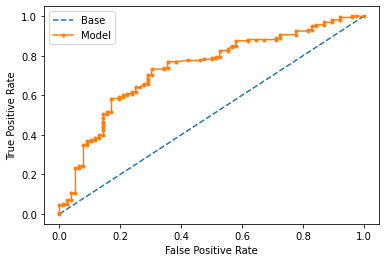

Model: ROC AUC=0.712


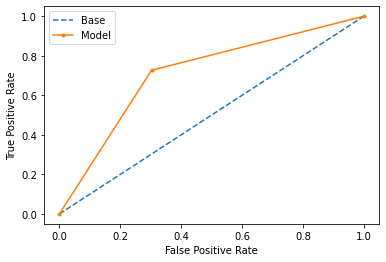

Model: ROC AUC=0.703


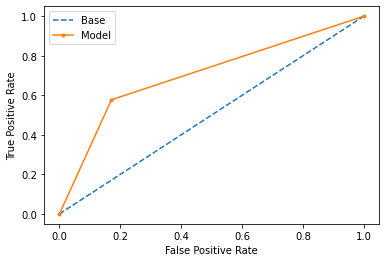

Model: ROC AUC=0.627


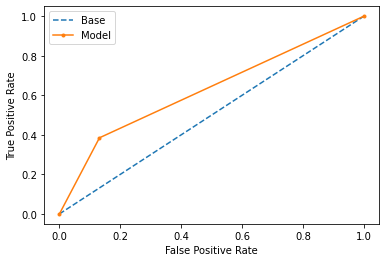

In [28]:
plot_roc(y_future_test, pred_probs[:, 1])
plot_roc(y_future_test, preds)
plot_roc(y_future_test, df_thresholds['Pred_with_Threshold_0.7'])
plot_roc(y_future_test, df_thresholds['Pred_with_Threshold_0.8'])

### Plot the distributions

<AxesSubplot:xlabel='churn_proba_1', ylabel='Count'>

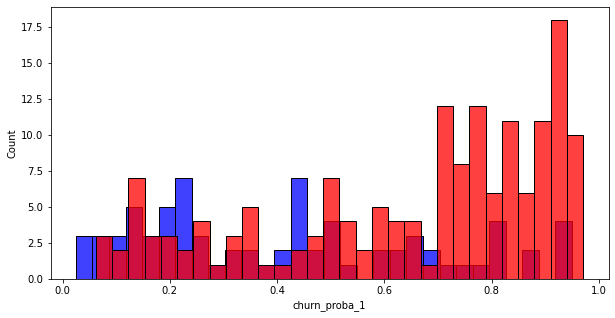

In [42]:
df_new_users_churn_probs = pd.concat([df_ACTIVE_1_order_users[['user_id', 'churn_2nd_order_UPDATED']].reset_index()
           , pd.DataFrame(pred_probs)]
           ,axis=1)

df_new_users_churn_probs = df_new_users_churn_probs.drop(columns=['index'])

df_new_users_churn_probs.columns = ['user_id', 'churn_2nd_order_UPDATED', 'churn_proba_0', 'churn_proba_1']

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=df_new_users_churn_probs[df_new_users_churn_probs['churn_2nd_order_UPDATED']==0], x='churn_proba_1', bins=30, color='blue', ax=ax)
sns.histplot(data=df_new_users_churn_probs[df_new_users_churn_probs['churn_2nd_order_UPDATED']==1], x='churn_proba_1', bins=30, color='red', ax=ax)

### Plot Recall Vs Precision Curve

XGB: f1=0.777 auc=0.838


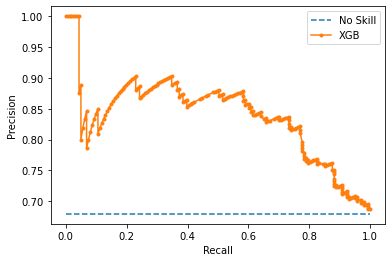

In [30]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
lr_probs = pred_probs # model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = preds # model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(y_future_test, lr_probs)
lr_f1, lr_auc = f1_score(y_future_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('XGB: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_future_test[y_future_test==1]) / len(y_future_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGB')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Save the model

In [31]:
# save model to file
#pickle.dump(cv_bayes_search_XGB.best_estimator_, open("2nd_order_churn_cv_bayes_search_XGB_19Nov2020.pickle.dat", "wb"))

## Model Explainability - SHAP

### Refit a copy of the performance model

In [32]:
cat_cols_red_RF = list(set(X[most_important_feats_RF].select_dtypes(include=['object']).columns.tolist()))
int_cols_red_RF = list(set(X[most_important_feats_RF].select_dtypes(include=['int', 'int64']).columns.tolist()))
num_cols_red_RF = [x for x in X[most_important_feats_RF].columns if x not in cat_cols_red_RF + int_cols_red_RF + target_col]

preprocessor_red_feats = ColumnTransformer(
    [
         ('categoricals', categorical_transformer, cat_cols_red_RF)
        ,('integers', integer_transformer, int_cols_red_RF)
        ,('numericals', continuous_transformer, num_cols_red_RF)
    ],
    remainder = 'drop'
)

xgb_best_clf_shap=cv_bayes_search_XGB.best_params_['clf']

xgb_best_clf_pip = Pipeline(
    [
        ('preprocessing', preprocessor_red_feats),
        ('clf', xgb_best_clf_shap)
    ]
)

xgb_best_clf_pip.fit(X_train[most_important_feats_RF], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['payment_method_1st_order']),
                                                 ('integers',
                                                  Pipeline(steps=[('imputer_int',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['through_subscription_1st_order']),
                                                 ('n...
                               interaction_constraint

### Extract feature names in the right positions, as well as the one-hot encoded categorical variables

In [33]:
categorical_feats_idx = xgb_best_clf_pip.named_steps.preprocessing.transformers[0][2]
integer_feats_idx = xgb_best_clf_pip.named_steps.preprocessing.transformers[1][2]
numerical_feats_idx = xgb_best_clf_pip.named_steps.preprocessing.transformers[2][2]

ohe_xgb = xgb_best_clf_pip.named_steps.preprocessing.transformers_[0][1].named_steps.onehot

cat_enc_feat_names_xbg = ohe_xgb.get_feature_names(categorical_feats_idx)

columns_transform=list(cat_enc_feat_names_xbg.copy())
columns_transform.extend(integer_feats_idx.copy())
columns_transform.extend(numerical_feats_idx.copy())

In [34]:
shap.initjs()

# Use the original pipeline only for this step, otherwise the pipeline gets corrupted
X_train_preproc = cv_bayes_search_XGB.best_estimator_.named_steps.preprocessing.transform(X_train[most_important_feats_RF])

# Use a copy of the model here, with the best params of the pipeline and retrained
xgb_from_pip = xgb_best_clf_pip.named_steps.clf
shap_values_XGB_train = shap.TreeExplainer(xgb_from_pip).shap_values(X_train_preproc)

### Plot the SHAP Summary Plot as a bar chart

In [ ]:
shap.summary_plot(shap_values=shap_values_XGB_train, features=X_train_preproc, feature_names=columns_transform
                 , max_display=-1, plot_type="bar")

### Plot the SHAP Summary Plot as a tornado chart

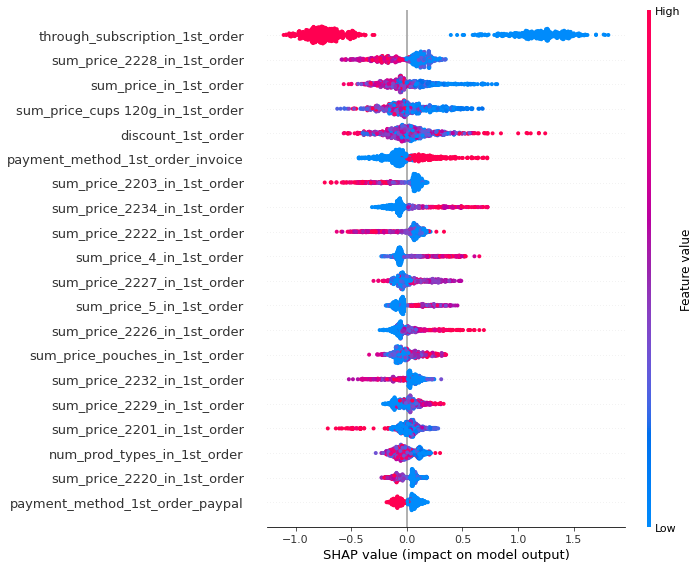

In [36]:
shap.summary_plot(shap_values=shap_values_XGB_train, features=X_train_preproc, feature_names=columns_transform)

### Plot the SHAP dependence plot for a key feature

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


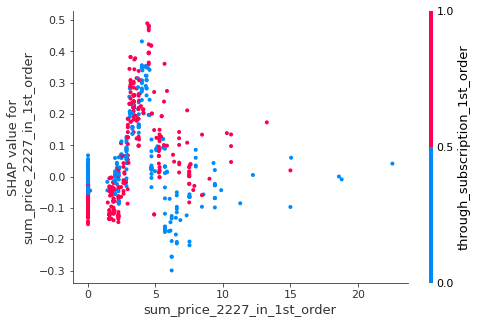

In [37]:
shap.dependence_plot(ind="sum_price_2227_in_1st_order"
                     , shap_values=shap_values_XGB_train
                     , features=X_train_preproc
                     ,feature_names=columns_transform)